In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

## LGBMRegressor

In [ ]:
# !pip install deepctr-torch
# !pip install lightgbm
# !pip install optuna

In [93]:
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, MinMaxScaler
import matplotlib.pyplot as plt
from deepctr_torch.inputs import SparseFeat, get_feature_names, DenseFeat
from deepctr_torch.models import DeepFM
from sklearn.metrics import mean_absolute_error
import numpy as np
from lightgbm import LGBMRegressor,plot_importance,Dataset

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Main Train 파일 로드
Ori_Train = pd.read_csv('./Train/Train.csv', encoding='utf-8')

# 엑셀파일이기에 read_excel로 로드
Sub_Data = pd.read_excel('./Train/ETC_Data/Main_Subjects.xlsx')

# test file 업로드

test = pd.read_csv('Test.csv')

# 제출 파일 업로드
submission = pd.read_csv('Sample_Submission.csv')
submission = submission.drop(columns = ['Unnamed: 0'])

In [3]:
Basic = pd.read_excel('Train/ETC_Data/Basic.xlsx')
# Detail_Info = pd.read_excel('Train/ETC_Data/Detail_Info.xlsx')
# Main_Subjects = pd.read_excel('Train/ETC_Data/Main_Subjects.xlsx')
# Medical_Facility = pd.read_excel('Train/ETC_Data/Medical_Facility.xlsx')
# Reception_Reservation_Days = pd.read_csv('Train/ETC_Data/Reception_Reservation_Days_2022.CSV',encoding='utf-8')
# Transportation = pd.read_excel('Train/ETC_Data/Transportation.xlsx')

In [4]:
# Primary Key 별로 진료과목 정리
Sub_Data = Sub_Data.groupby(['암호화요양기호'])['진료과목코드명'].apply(','.join).reset_index()
# 오름차순 정렬
Sub_Data['진료과목코드명'] = Sub_Data['진료과목코드명'].apply(lambda x: sorted(set(x.split(','))))

In [5]:
# Basic Data를 보고 nan값을 채워넣을 수 있을지

Basic = Basic[['암호화요양기호', '좌표(X)', '좌표(Y)']]
Sub_Basic = pd.merge(Sub_Data, Basic, left_on='암호화요양기호', right_on='암호화요양기호', how='left')
Sub_Basic

,암호화요양기호,진료과목코드명,좌표(X),좌표(Y)
0,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[가정의학과, 내과, 비뇨의학과, 사상체질과, 산부인과, 침구과, 한방내과, 한방부...",129.036996,35.099979
1,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 재활의학과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신...",129.044640,35.126467
2,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[영상의학과, 침구과, 한방내과, 한방신경정신과, 한방안·이비인후·피부과, 한방재활...",129.175263,35.169667
3,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 재활의학과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신...",129.077525,35.205376
4,JDQ4MTAxMiM1MSMkMSMkMCMkMTMkMzgxMTkxIzExIyQxIy...,"[사상체질과, 정형외과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과...",129.099260,35.137340
...,...,...,...,...
72583,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 산부인과, 성형외과, 피부과]",127.154242,37.508778
72584,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 내과, 비뇨의학과, 소아청소년과, 이비인후과, 피부과]",127.112248,37.650579
72585,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,"[가정의학과, 피부과]",127.244136,37.654116
72586,JDU4MTI3MSM1MSMkMiMkMCMkMDAkNTgxMzUxIzIxIyQyIy...,[이비인후과],126.712599,37.593903


### 전처리 방향

columns 추가

'USER_ID', 'Question_ID', 'HOSPITAL_CD', 'HOSPITAL_NM', 'TIME', '종별코드', '시도코드명',
       '시군구코드', '개설일자', '총의사수', 'x좌표', 'y좌표'


X,Y 좌표는 일단 평균값으로 전처리 한다

time 날짜 떼고 min max scaling

개설일자(개원일 예상, 오랫동안 운영했을 경우 평점이 더 높을까)


좌표(X)와 x좌표 중 큰 값으로 최대한 Nan값을 채웠다

둘 다 Nan 값을 가지는 것은 18개

이건 버릴건지?
평균으로 채울건지?

## 추가로 고려해 볼 feature
- TIME? , 총의사수

Question_ID = USER_ID + HOSPITAL_ID = Identity_ID

In [22]:
# Data Merge
Merged_Train = pd.merge(Ori_Train, Sub_Basic, left_on='HOSPITAL_CD', right_on='암호화요양기호',how='left')
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,병원홈페이지(URL),개설일자,총의사수,x좌표,y좌표,Identity_Key,암호화요양기호,진료과목코드명,좌표(X),좌표(Y)
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,NaN,2021-04-12 00:00:00,1,127.071848,37.534118,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]",127.071848,37.534118
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,NaN,1995-06-17 00:00:00,1,126.905218,37.479841,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]",126.905218,37.479841
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,NaN,2022-04-20 00:00:00,1,NaN,NaN,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과],127.089398,37.580735
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,NaN,2019-02-07 00:00:00,1,127.070530,37.456457,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·...",127.070530,37.456457


In [23]:
x = []
y = []

for i in range(48438):
    if Merged_Train['좌표(X)'][i] > Merged_Train['x좌표'][i]:
        x.append(Merged_Train['좌표(X)'][i])
    elif Merged_Train['좌표(X)'][i] <= Merged_Train['x좌표'][i]:
        x.append(Merged_Train['x좌표'][i])
    else:
        x.append(np.nan)

for j in range(48438):
    if Merged_Train['좌표(Y)'][j] > Merged_Train['y좌표'][j]:
        y.append(Merged_Train['좌표(Y)'][j])
    elif Merged_Train['좌표(Y)'][j] <= Merged_Train['y좌표'][j]:
        y.append(Merged_Train['y좌표'][j])
    else:
        y.append(np.nan)

In [24]:
xy = pd.DataFrame([x for x in zip(x, y)])
xy.columns =['x', 'y']
xy

,x,y
0,127.021476,37.517322
1,127.021476,37.517322
2,127.021476,37.517322
3,127.021476,37.517322
4,127.021476,37.517322
...,...,...
48433,127.071848,37.534118
48434,126.905218,37.479841
48435,NaN,NaN
48436,127.070530,37.456457


In [25]:
Merged_Train = pd.concat([Merged_Train, xy], axis=1)
Merged_Train = Merged_Train.drop(columns = ['x좌표', 'y좌표', '좌표(X)', '좌표(Y)'])
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,Identity_Key,암호화요양기호,진료과목코드명,x,y
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,광진구,02-6953-5805,NaN,2021-04-12 00:00:00,1,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]",127.071848,37.534118
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,금천구,02-859-3500,NaN,1995-06-17 00:00:00,1,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]",126.905218,37.479841
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,중랑구,02-2038-3070,NaN,2022-04-20 00:00:00,1,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과],NaN,NaN
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,서초구,02-529-7522,NaN,2019-02-07 00:00:00,1,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·...",127.070530,37.456457


In [26]:
# NaN값 처리
Merged_Train.dropna(subset=['진료과목코드명'], inplace=True)
# Merged_Train[Merged_Train.isna().any(axis=1)]
# Merged_Train.dropna(subset=['x'], inplace = True)
# Merged_Train['진료과목코드명'] = Merged_Train['진료과목코드명'].fillna('X')

In [27]:
# 중앙값(df.median)으로 NaN 채우기, 최빈값 df.mode(), 최대값

# Final_Train[Final_Train.isna().any(axis=1)]
# Final_Train = Final_Train.dropna()
# Final_Train = Final_Train.fillna(Final_Train.median(numeric_only = True))
Merged_Train['x'] = Merged_Train['x'].fillna(Merged_Train['x'].mode()[0])
Merged_Train['y'] = Merged_Train['y'].fillna(Merged_Train['y'].mode()[0])
Merged_Train

,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,HOSPITAL_NM,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,Identity_Key,암호화요양기호,진료과목코드명,x,y
0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,477865_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,201033325523_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,338181_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,201032630325_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,499849_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과],127.021476,37.517322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,벗이비인후과의원,...,광진구,02-6953-5805,NaN,2021-04-12 00:00:00,1,2440542_72069,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,"[내과, 소아청소년과, 신경과, 이비인후과]",127.071848,37.534118
48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,전영수내과의원,...,금천구,02-859-3500,NaN,1995-06-17 00:00:00,1,1658243_73445,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,"[내과, 소아청소년과]",126.905218,37.479841
48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,마음담은정신건강의학과의원,...,중랑구,02-2038-3070,NaN,2022-04-20 00:00:00,1,2445760_79673,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,[정신건강의학과],127.024134,37.506211
48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,다스름한의원,...,서초구,02-529-7522,NaN,2019-02-07 00:00:00,1,2452015_25306,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·...",127.070530,37.456457


In [28]:
Merged_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48436 entries, 0 to 48437
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    48436 non-null  int64  
 1   USER_ID       48436 non-null  float64
 2   REG_DATE      48436 non-null  object 
 3   TOTAL_RATE    48436 non-null  float64
 4   TX_RATE       48436 non-null  float64
 5   SERVICE_RATE  48436 non-null  float64
 6   ETC_RATE      48436 non-null  float64
 7   CONTENTS      43901 non-null  object 
 8   HOSPITAL_CD   48436 non-null  object 
 9   HOSPITAL_NM   48436 non-null  object 
 10  ADD           48436 non-null  object 
 11  HOSPITAL_ID   48436 non-null  int64  
 12  TIME          48436 non-null  object 
 13  요양기관명         48436 non-null  object 
 14  종별코드          48436 non-null  int64  
 15  종별코드명         48436 non-null  object 
 16  시도코드          48436 non-null  int64  
 17  시도코드명         48436 non-null  object 
 18  시군구코드         48436 non-nu

In [29]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Train['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value, columns = Hospital_Class)
Merged_Train = Merged_Train.drop('진료과목코드명', axis=1).reset_index()

Refined_Train = pd.concat([Merged_Train, One_Hot_Classes], axis=1)

In [30]:
Refined_Train

,index,Unnamed: 0,USER_ID,REG_DATE,TOTAL_RATE,TX_RATE,SERVICE_RATE,ETC_RATE,CONTENTS,HOSPITAL_CD,...,진료과목_피부과,진료과목_한방내과,진료과목_한방부인과,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과
0,0,0,4.778650e+05,2018-07-23 09:24:08,9.0,8.0,10.0,8.0,볼지방제거와 밴드리프팅 한지 한달됐어요 많이 가름해졌어요 좀더 지켜봐야 할것같다,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2.010333e+11,2018-07-23 09:59:15,10.0,10.0,10.0,10.0,너무좋은데. 아직 좀지켜봐야알겠지만 예뻐질것같은 느낌이예요,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,0,0,0,0,0,0,0,0,0,0
2,2,2,3.381810e+05,2018-07-23 10:00:57,10.0,10.0,10.0,10.0,꼭당첨!!!,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,0,0,0,0,0,0,0,0,0,0
3,3,3,2.010326e+11,2018-07-24 12:57:55,5.0,6.0,6.0,4.0,무제한 보톡스 는 아닌것 같아요 보톡스를 맞기 위한 옷 이 없어 기다림 남이 입건것...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4.998490e+05,2018-07-25 10:08:18,10.0,10.0,10.0,10.0,NaN,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48431,48433,167863,2.440542e+06,2022-09-25 04:32:05.963774,8.0,6.0,10.0,10.0,시설 좋고 선생님도 젊으세요 대신 사람이 많아서 그만큼 많이 기다려야해요 수액 놓는...,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzUxIyQxIy...,...,0,0,0,0,0,0,0,0,0,0
48432,48434,167864,1.658243e+06,2022-09-27 01:22:27.485015,6.0,6.0,6.0,6.0,소이과 되어있어서 왔는데 소아과가 없대서 아가인고 돌아갑니다 ㅜㅜ,JDQ4MTg4MSM1MSMkMiMkMCMkMDAkNDgxNzAyIzExIyQxIy...,...,0,0,0,0,0,0,0,0,0,0
48433,48435,167865,2.445760e+06,2022-09-27 05:42:37.378565,10.0,10.0,10.0,10.0,좋은말씀 많이해주세요,JDQ4MTg4MSM1MSMkMiMkOCMkMDAkMzgxMzUxIzIxIyQxIy...,...,0,0,0,0,0,0,0,0,0,0
48434,48436,167866,2.452015e+06,2022-10-02 02:04:41.373758,10.0,10.0,10.0,10.0,명의이십니다 보통 한의원과는 차원이 달라요 아토피 정신과 허리 치료 받았습니다,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxMTkxIzUxIyQxIy...,...,0,1,1,1,1,1,0,1,0,0


In [31]:
# test data에 없는 컬럼 제거
Refined_Train = Refined_Train.drop(columns='진료과목_비뇨기과')

In [32]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드', 'x', 'y']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Train.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x','y']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))
Refined_Train[CONT_FIELDS] = mms.fit_transform(Refined_Train[CONT_FIELDS])

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Train[feat] = lbe.fit_transform(Refined_Train[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Train[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Train_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Train_Columns.append('TOTAL_RATE')

Final_Train = Refined_Train[DeepFM_Train_Columns].reset_index().drop(columns=['index'])



In [33]:
Final_Train

,HOSPITAL_ID,시군구코드,USER_ID,진료과목_가정의학과,진료과목_결핵과,진료과목_구강내과,진료과목_구강병리과,진료과목_구강악안면외과,진료과목_내과,진료과목_마취통증의학과,...,진료과목_한방소아과,진료과목_한방신경정신과,진료과목_한방안·이비인후·피부과,진료과목_한방응급,진료과목_한방재활의학과,진료과목_핵의학과,진료과목_흉부외과,x,y,TOTAL_RATE
0,5419,0,6201,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225718,0.932982,9.0
1,5419,0,37701,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225718,0.932982,10.0
2,5419,0,3855,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225718,0.932982,10.0
3,5419,0,37634,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225718,0.932982,5.0
4,5419,0,6739,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.225718,0.932982,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48431,4960,22,36589,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.244066,0.936719,8.0
48432,5064,24,33045,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.183371,0.924642,6.0
48433,5405,18,36599,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.226686,0.930510,10.0
48434,1753,20,36613,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0.243586,0.919438,10.0


<AxesSubplot: >

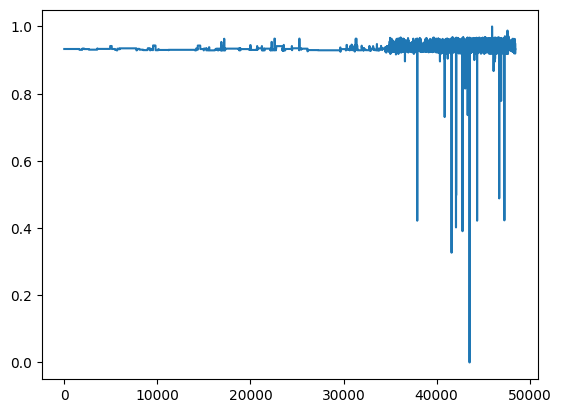

In [34]:
# Final_Train['x좌표'].describe()
Final_Train['y'].plot()

In [ ]:
'''
 x, y 좌표 빼 보기
'''

# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Train.columns if k.startswith('진료과목')]

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Train[feat] = lbe.fit_transform(Refined_Train[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Train[feat].nunique()) for feat in CAT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Train_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Train_Columns.append('TOTAL_RATE')

Final_Train = Refined_Train[DeepFM_Train_Columns]
# NaN 값 채우기
# Final_Train[Final_Train.isna().any(axis=1)]
Final_Train = Final_Train.fillna(0)
Final_Train

In [ ]:
# 모델 결과 출력
plt.plot(history.history["loss"])
plt.plot(history.history["val_mse"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"], loc="upper left")
plt.show()

## test data 전처리

In [66]:
# train data와 같은 방식으로 Sub_Data와 Merge

# Merged_Test = pd.merge(test, Sub_Basic, left_on='HOSPITAL_CD',right_on='암호화요양기호',how='left')
Merged_Test = pd.merge(test, Sub_Data, left_on='HOSPITAL_CD',right_on='암호화요양기호',how='left')

In [70]:
Merged_Test = Merged_Test.rename(columns={'x좌표':'x', 'y좌표':'y'})

In [71]:
Merged_Test[Merged_Test['진료과목코드명'].isna()]

,Unnamed: 0,USER_ID,Question_ID,HOSPITAL_CD,HOSPITAL_NM,ADD,HOSPITAL_ID,TIME,요양기관명,종별코드,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x,y,Predict_Score,암호화요양기호,진료과목코드명


In [38]:
x_t = []
y_t = []

for i in range(1406):
    if Merged_Test['좌표(X)'][i] > Merged_Test['x좌표'][i]:
        x_t.append(Merged_Test['좌표(X)'][i])
    elif Merged_Test['좌표(X)'][i] <= Merged_Test['x좌표'][i]:
        x_t.append(Merged_Test['x좌표'][i])
    else:
        x_t.append(np.nan)

for j in range(1406):
    if Merged_Test['좌표(Y)'][j] > Merged_Test['y좌표'][j]:
        y_t.append(Merged_Test['좌표(Y)'][j])
    elif Merged_Test['좌표(Y)'][j] <= Merged_Test['y좌표'][j]:
        y_t.append(Merged_Test['y좌표'][j])
    else:
        y_t.append(np.nan)


In [39]:
xy_t = pd.DataFrame([x for x in zip(x_t, y_t)])
xy_t.columns =['x', 'y']
xy_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1389 non-null   float64
 1   y       1389 non-null   float64
dtypes: float64(2)
memory usage: 22.1 KB


In [40]:
Merged_Test = pd.concat([Merged_Test, xy_t], axis=1)
Merged_Test = Merged_Test.drop(columns = ['x좌표', 'y좌표', '좌표(X)', '좌표(Y)'])
# Merged_Test.dropna(subset=['x','y'], inplace = True)
Merged_Test.reset_index(inplace=True)

In [72]:
Merged_Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 1405
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1406 non-null   int64  
 1   USER_ID        1406 non-null   int64  
 2   Question_ID    1406 non-null   object 
 3   HOSPITAL_CD    1406 non-null   object 
 4   HOSPITAL_NM    1406 non-null   object 
 5   ADD            1406 non-null   object 
 6   HOSPITAL_ID    1406 non-null   int64  
 7   TIME           1406 non-null   object 
 8   요양기관명          1406 non-null   object 
 9   종별코드           1406 non-null   int64  
 10  종별코드명          1406 non-null   object 
 11  시도코드           1406 non-null   int64  
 12  시도코드명          1406 non-null   object 
 13  시군구코드          1406 non-null   int64  
 14  시군구코드명         1406 non-null   object 
 15  전화번호           1381 non-null   object 
 16  병원홈페이지(URL)    475 non-null    object 
 17  개설일자           1406 non-null   object 
 18  총의사수    

In [73]:


# Final_Test[Final_Test.isna().any(axis=1)]
# Final_Test = Final_Test.dropna()
# Final_Test

# Final_Test = Final_Test.fillna(Final_Test.median(numeric_only = True))
'''
# x,y 좌표 Basic과 연계
Merged_Test['x'] = Merged_Test['x'].fillna(Merged_Test['x'].mode()[0])
Merged_Test['y'] = Merged_Test['y'].fillna(Merged_Test['y'].mode()[0])
'''
# test data 기본 data + 평균값
Merged_Test['x'] = Merged_Test['x'].fillna(Merged_Test['x'].mode()[0])
Merged_Test['y'] = Merged_Test['y'].fillna(Merged_Test['y'].mode()[0])

Merged_Test

,Unnamed: 0,USER_ID,Question_ID,HOSPITAL_CD,HOSPITAL_NM,ADD,HOSPITAL_ID,TIME,요양기관명,종별코드,...,시군구코드명,전화번호,병원홈페이지(URL),개설일자,총의사수,x,y,Predict_Score,암호화요양기호,진료과목코드명
0,1,1034825,1034825_85156,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,리팅성형외과의원,서울특별시 강남구 도산대로 119 K타워 5층,85156,2020-09-11 17:19:48,리팅성형외과의원,31,...,강남구,1899-9717,http://www.yonseiplus.com,2016-09-07 00:00:00,25,127.020169,37.515876,1,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMzUxIzMxIyQxIy...,[성형외과]
1,9,201020684119,201020684119_33732,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxNzAyIzMxIyQxIy...,로담한의원 강남점,"서울특별시 강남구 강남대로 498 3층 (논현동, 명성빌딩)",33732,2019-10-21 00:25:48,로담한의원,93,...,강남구,3444-7523,http://www.skincora.com,2015-10-21 00:00:00,4,127.023893,37.506695,1,JDQ4MTg4MSM1MSMkMSMkMCMkMTMkNDgxNzAyIzMxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·..."
2,13,1078855,1078855_203038,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxMzUxIzMxIyQyIy...,나나성형외과,"서울특별시 강남구 강남대로 492, 지상 2층",203038,2020-01-10 05:12:27,나나성형외과의원,31,...,강남구,02-544-0601,NaN,2018-05-28 00:00:00,20,127.024119,37.506211,1,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxMzUxIzMxIyQyIy...,[성형외과]
3,14,1501770,1501770_47123,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzExIyQxIy...,리스펙성형외과의원,서울특별시 서초구 강남대로 441 서산빌딩 6층 (서초동),47123,2021-06-01 03:56:31,리스펙성형외과의원,31,...,서초구,02-532-0888,NaN,2019-10-31 00:00:00,2,127.025305,37.501747,1,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzExIyQxIy...,"[마취통증의학과, 성형외과, 피부과]"
4,16,582814,582814_54799,JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxOTYxIzMxIyQxIy...,자연과한의원 노원점,서울특별시 노원구 동일로 1417 2층,54799,2022-04-12 09:10:37,자연과한의원,93,...,노원구,02-951-1357,NaN,2012-04-05 00:00:00,1,127.059991,37.655041,1,JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxOTYxIzMxIyQxIy...,"[사상체질과, 침구과, 한방내과, 한방부인과, 한방소아과, 한방신경정신과, 한방안·..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,3605,1405162,1405162_116235,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMTkxIzIxIyQxIy...,시안의원,"서울특별시 서초구 강남대로 439 8층 (서초동, 유화빌딩)",116235,2020-10-24 10:26:53,시안의원,31,...,서초구,534-5555,NaN,2013-10-15 00:00:00,3,127.025402,37.501546,1,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNDgxMTkxIzIxIyQxIy...,"[성형외과, 피부과]"
1402,3607,1405162,1405162_85781,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkMzgxMTkxIzUxIyQxIy...,재시아성형외과의원,"서울특별시 강남구 선릉로 840, 3층",85781,2020-10-24 10:24:35,재시아성형외과의원,31,...,강남구,3442-1991,http://www.jaessia.com,1999-10-18 00:00:00,1,127.040740,37.526802,1,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkMzgxMTkxIzUxIyQxIy...,[성형외과]
1403,3609,1405162,1405162_229060,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzIxIyQxIy...,강남역 데이원의원,서울특별시 서초구 강남대로 423 한승빌딩 4층 402호 (서초동),229060,2020-12-01 10:19:08,강남역데이원의원,31,...,서초구,02-594-5001,NaN,2019-12-03 00:00:00,1,127.025845,37.500259,1,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkNTgxOTYxIzIxIyQxIy...,"[성형외과, 피부과]"
1404,3627,1410677,1410677_76169,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkMzgxMTkxIzMxIyQxIy...,유앤아이의원 영등포점,서울특별시 영등포구 영중로 12 에쉐르빌딩 7층,76169,2021-09-08 04:46:22,유앤아이의원,31,...,영등포구,02-2636-6020,http://www.blueuro.co.kr,2018-10-12 00:00:00,6,126.906519,37.517634,1,JDQ4MTg4MSM1MSMkMiMkNCMkMDAkMzgxMTkxIzMxIyQxIy...,[피부과]


In [74]:
Merged_Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 1405
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1406 non-null   int64  
 1   USER_ID        1406 non-null   int64  
 2   Question_ID    1406 non-null   object 
 3   HOSPITAL_CD    1406 non-null   object 
 4   HOSPITAL_NM    1406 non-null   object 
 5   ADD            1406 non-null   object 
 6   HOSPITAL_ID    1406 non-null   int64  
 7   TIME           1406 non-null   object 
 8   요양기관명          1406 non-null   object 
 9   종별코드           1406 non-null   int64  
 10  종별코드명          1406 non-null   object 
 11  시도코드           1406 non-null   int64  
 12  시도코드명          1406 non-null   object 
 13  시군구코드          1406 non-null   int64  
 14  시군구코드명         1406 non-null   object 
 15  전화번호           1381 non-null   object 
 16  병원홈페이지(URL)    475 non-null    object 
 17  개설일자           1406 non-null   object 
 18  총의사수    

In [75]:
# Muliti Label Onehot
mlb = MultiLabelBinarizer()
Encoded_Value = mlb.fit_transform(Merged_Test['진료과목코드명'])
Hospital_Class = mlb.classes_
Hospital_Class = ['진료과목'+'_'+ k for k in Hospital_Class]
One_Hot_Classes = pd.DataFrame(Encoded_Value, columns = Hospital_Class)
Merged_Test = Merged_Test.drop('진료과목코드명', axis=1)

Refined_Test = pd.concat([Merged_Test, One_Hot_Classes], axis=1)

In [76]:
# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드', 'x', 'y']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Test.columns if k.startswith('진료과목')]

# 연속형 변수가 담긴 Column
CONT_FIELDS = ['x','y']

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS).difference(CONT_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))
Refined_Test[CONT_FIELDS] = mms.fit_transform(Refined_Test[CONT_FIELDS])

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Test[feat] = lbe.fit_transform(Refined_Test[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Test[feat].nunique()) for feat in CAT_FIELDS] + [DenseFeat(feat,1,)for feat in CONT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Test_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Test_Columns.append('Predict_Score')

Final_Test = Refined_Test[DeepFM_Test_Columns]


In [ ]:
'''
x, y 좌표 빼 보기
'''

# 학습에 활용할 모든 Column
ALL_FIELDS = ['USER_ID', 'HOSPITAL_ID', '시군구코드']

# 학습에 활용할 모든 Column
Subject_FIELDS = [k for k in Refined_Test.columns if k.startswith('진료과목')]

# 범주형 변수가 담긴 Column > One Hot Encoding으로 변경해야함
CAT_FIELDS = list(set(ALL_FIELDS)) + Subject_FIELDS

mms = MinMaxScaler(feature_range=(0,1))

for feat in CAT_FIELDS:
    lbe = LabelEncoder()
    Refined_Test[feat] = lbe.fit_transform(Refined_Test[feat])

fixlen_feature_columns = [SparseFeat(feat, Refined_Test[feat].nunique()) for feat in CAT_FIELDS]
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

DeepFM_Test_Columns = get_feature_names(fixlen_feature_columns)
DeepFM_Test_Columns.append('Predict_Score')

Final_Test = Refined_Test[DeepFM_Test_Columns]
# Final_Test[Final_Test.isna().any(axis=1)]

Final_Test = Final_Test.fillna(0)
Final_Test

## LGBM 추가 앙상블 모델로서 학습하기?



In [77]:
for k in CAT_FIELDS:
    Final_Train[k]=Final_Train[k].astype('category')
    
lgbm_train_columns = get_feature_names(fixlen_feature_columns) 
    
X_train, X_test, y_train, y_test = train_test_split(Final_Train[lgbm_train_columns], Final_Train['TOTAL_RATE'], test_size=0.2, random_state = 1042)

In [78]:
lgbm_wrapper = LGBMRegressor(max_depth=20, min_child_samples=60, n_estimators=1000,
              num_leaves=50, subsample=0.8)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 1500, eval_metric='mae', eval_set = evals, verbose=True)

/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages

[1]	valid_0's l1: 1.65165	valid_0's l2: 4.47337
[2]	valid_0's l1: 1.62044	valid_0's l2: 4.35418
[3]	valid_0's l1: 1.59248	valid_0's l2: 4.25742
[4]	valid_0's l1: 1.56744	valid_0's l2: 4.17881
[5]	valid_0's l1: 1.54526	valid_0's l2: 4.1154
[6]	valid_0's l1: 1.5258	valid_0's l2: 4.06324
[7]	valid_0's l1: 1.50939	valid_0's l2: 4.0216
[8]	valid_0's l1: 1.49475	valid_0's l2: 3.98645
[9]	valid_0's l1: 1.48174	valid_0's l2: 3.95688
[10]	valid_0's l1: 1.4704	valid_0's l2: 3.93379
[11]	valid_0's l1: 1.4605	valid_0's l2: 3.91515
[12]	valid_0's l1: 1.45182	valid_0's l2: 3.89894
[13]	valid_0's l1: 1.44433	valid_0's l2: 3.88692
[14]	valid_0's l1: 1.43782	valid_0's l2: 3.87715
[15]	valid_0's l1: 1.43179	valid_0's l2: 3.86796
[16]	valid_0's l1: 1.42647	valid_0's l2: 3.86056
[17]	valid_0's l1: 1.42153	valid_0's l2: 3.85369
[18]	valid_0's l1: 1.41732	valid_0's l2: 3.84802
[19]	valid_0's l1: 1.41299	valid_0's l2: 3.84271
[20]	valid_0's l1: 1.40925	valid_0's l2: 3.83798
[21]	valid_0's l1: 1.40596	valid_0

[182]	valid_0's l1: 1.36563	valid_0's l2: 3.80685
[183]	valid_0's l1: 1.36556	valid_0's l2: 3.80679
[184]	valid_0's l1: 1.36555	valid_0's l2: 3.80673
[185]	valid_0's l1: 1.36555	valid_0's l2: 3.80699
[186]	valid_0's l1: 1.36545	valid_0's l2: 3.80717
[187]	valid_0's l1: 1.36538	valid_0's l2: 3.80677
[188]	valid_0's l1: 1.36527	valid_0's l2: 3.80671
[189]	valid_0's l1: 1.36535	valid_0's l2: 3.80717
[190]	valid_0's l1: 1.36534	valid_0's l2: 3.80762
[191]	valid_0's l1: 1.36521	valid_0's l2: 3.80768
[192]	valid_0's l1: 1.36512	valid_0's l2: 3.80768
[193]	valid_0's l1: 1.36502	valid_0's l2: 3.80748
[194]	valid_0's l1: 1.36497	valid_0's l2: 3.8073
[195]	valid_0's l1: 1.3649	valid_0's l2: 3.80733
[196]	valid_0's l1: 1.36482	valid_0's l2: 3.80706
[197]	valid_0's l1: 1.36477	valid_0's l2: 3.80712
[198]	valid_0's l1: 1.36466	valid_0's l2: 3.80712
[199]	valid_0's l1: 1.36456	valid_0's l2: 3.80684
[200]	valid_0's l1: 1.36452	valid_0's l2: 3.80661
[201]	valid_0's l1: 1.36444	valid_0's l2: 3.80636
[2

[372]	valid_0's l1: 1.35851	valid_0's l2: 3.81629
[373]	valid_0's l1: 1.35845	valid_0's l2: 3.81631
[374]	valid_0's l1: 1.35846	valid_0's l2: 3.81635
[375]	valid_0's l1: 1.35842	valid_0's l2: 3.81634
[376]	valid_0's l1: 1.3584	valid_0's l2: 3.81623
[377]	valid_0's l1: 1.35839	valid_0's l2: 3.81647
[378]	valid_0's l1: 1.35837	valid_0's l2: 3.81629
[379]	valid_0's l1: 1.35835	valid_0's l2: 3.81639
[380]	valid_0's l1: 1.35833	valid_0's l2: 3.81648
[381]	valid_0's l1: 1.35815	valid_0's l2: 3.81616
[382]	valid_0's l1: 1.35809	valid_0's l2: 3.81611
[383]	valid_0's l1: 1.35812	valid_0's l2: 3.81611
[384]	valid_0's l1: 1.3581	valid_0's l2: 3.81617
[385]	valid_0's l1: 1.35807	valid_0's l2: 3.81629
[386]	valid_0's l1: 1.35804	valid_0's l2: 3.81653
[387]	valid_0's l1: 1.358	valid_0's l2: 3.81661
[388]	valid_0's l1: 1.35794	valid_0's l2: 3.81669
[389]	valid_0's l1: 1.35798	valid_0's l2: 3.81686
[390]	valid_0's l1: 1.35792	valid_0's l2: 3.81685
[391]	valid_0's l1: 1.35803	valid_0's l2: 3.81712
[392

[562]	valid_0's l1: 1.35527	valid_0's l2: 3.82677
[563]	valid_0's l1: 1.35524	valid_0's l2: 3.82678
[564]	valid_0's l1: 1.35519	valid_0's l2: 3.8269
[565]	valid_0's l1: 1.3552	valid_0's l2: 3.82715
[566]	valid_0's l1: 1.35518	valid_0's l2: 3.82726
[567]	valid_0's l1: 1.35519	valid_0's l2: 3.82733
[568]	valid_0's l1: 1.35511	valid_0's l2: 3.82742
[569]	valid_0's l1: 1.35509	valid_0's l2: 3.82759
[570]	valid_0's l1: 1.35505	valid_0's l2: 3.82749
[571]	valid_0's l1: 1.35501	valid_0's l2: 3.82737
[572]	valid_0's l1: 1.35505	valid_0's l2: 3.82749
[573]	valid_0's l1: 1.35504	valid_0's l2: 3.82757
[574]	valid_0's l1: 1.35501	valid_0's l2: 3.82763
[575]	valid_0's l1: 1.35502	valid_0's l2: 3.82765
[576]	valid_0's l1: 1.35498	valid_0's l2: 3.82755
[577]	valid_0's l1: 1.355	valid_0's l2: 3.82778
[578]	valid_0's l1: 1.35498	valid_0's l2: 3.82779
[579]	valid_0's l1: 1.35501	valid_0's l2: 3.82797
[580]	valid_0's l1: 1.35499	valid_0's l2: 3.82816
[581]	valid_0's l1: 1.35502	valid_0's l2: 3.82829
[582

[754]	valid_0's l1: 1.35365	valid_0's l2: 3.83867
[755]	valid_0's l1: 1.35368	valid_0's l2: 3.83897
[756]	valid_0's l1: 1.35376	valid_0's l2: 3.83939
[757]	valid_0's l1: 1.35374	valid_0's l2: 3.83944
[758]	valid_0's l1: 1.35369	valid_0's l2: 3.83958
[759]	valid_0's l1: 1.35367	valid_0's l2: 3.83944
[760]	valid_0's l1: 1.35365	valid_0's l2: 3.83953
[761]	valid_0's l1: 1.35361	valid_0's l2: 3.8397
[762]	valid_0's l1: 1.35359	valid_0's l2: 3.83988
[763]	valid_0's l1: 1.35361	valid_0's l2: 3.84
[764]	valid_0's l1: 1.35366	valid_0's l2: 3.84037
[765]	valid_0's l1: 1.35367	valid_0's l2: 3.84059
[766]	valid_0's l1: 1.35362	valid_0's l2: 3.84032
[767]	valid_0's l1: 1.35363	valid_0's l2: 3.84035
[768]	valid_0's l1: 1.3536	valid_0's l2: 3.84029
[769]	valid_0's l1: 1.35356	valid_0's l2: 3.84022
[770]	valid_0's l1: 1.35355	valid_0's l2: 3.84011
[771]	valid_0's l1: 1.35354	valid_0's l2: 3.8402
[772]	valid_0's l1: 1.35355	valid_0's l2: 3.8402
[773]	valid_0's l1: 1.35348	valid_0's l2: 3.84014
[774]	v

[948]	valid_0's l1: 1.35329	valid_0's l2: 3.85269
[949]	valid_0's l1: 1.35326	valid_0's l2: 3.85274
[950]	valid_0's l1: 1.35328	valid_0's l2: 3.85293
[951]	valid_0's l1: 1.35327	valid_0's l2: 3.85304
[952]	valid_0's l1: 1.35328	valid_0's l2: 3.85323
[953]	valid_0's l1: 1.35333	valid_0's l2: 3.85345
[954]	valid_0's l1: 1.35331	valid_0's l2: 3.85347
[955]	valid_0's l1: 1.35332	valid_0's l2: 3.85356
[956]	valid_0's l1: 1.35333	valid_0's l2: 3.85367
[957]	valid_0's l1: 1.3533	valid_0's l2: 3.85365
[958]	valid_0's l1: 1.35328	valid_0's l2: 3.85367
[959]	valid_0's l1: 1.35333	valid_0's l2: 3.85393
[960]	valid_0's l1: 1.35331	valid_0's l2: 3.85379
[961]	valid_0's l1: 1.35333	valid_0's l2: 3.85386
[962]	valid_0's l1: 1.35338	valid_0's l2: 3.85403
[963]	valid_0's l1: 1.35338	valid_0's l2: 3.85413
[964]	valid_0's l1: 1.35335	valid_0's l2: 3.85419
[965]	valid_0's l1: 1.35332	valid_0's l2: 3.85418
[966]	valid_0's l1: 1.35332	valid_0's l2: 3.85411
[967]	valid_0's l1: 1.35329	valid_0's l2: 3.85418
[

LGBMRegressor(max_depth=20, min_child_samples=60, n_estimators=1000,
              num_leaves=50, subsample=0.8)

lgbm Test Data 실험

In [79]:
for k in CAT_FIELDS:
    Final_Test[k]=Final_Test[k].astype('category')
    
Final_Test_X = Final_Test.drop(columns=['Predict_Score'])
Final_Test_y = Final_Test.Predict_Score

/tmp/ipykernel_3485/596003663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_Test[k]=Final_Test[k].astype('category')
/tmp/ipykernel_3485/596003663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_Test[k]=Final_Test[k].astype('category')
/tmp/ipykernel_3485/596003663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [80]:
# test data 실험

predict = lgbm_wrapper.predict(Final_Test_X)
mean_squared_error(predict, Final_Test_y.values)

54.89167097998716

In [81]:
predict

array([8.82014725, 8.77831121, 8.82014725, ..., 8.26607563, 8.01589623,
       8.87815988])

In [82]:
predict = np.ceil(predict)

In [83]:
predict = np.where(predict > 10, 10, predict)
predict = np.where(predict < 0, 0, predict)

In [84]:
import datetime

In [85]:
submission['Predict_Score'] = predict

path = './result/'

now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
submission.to_csv(f'{path}Submission_{now}.csv',encoding='utf-8', index=False)

In [ ]:
ls

### 위에 사용한 Tree Model들의 Hyper Parameter는 설정하기 귀찮고 힘든데 Optuna로 설정해보는 것에 목적

In [86]:
import matplotlib.font_manager as fm

In [87]:
!apt -qq -y install fonts-nanum > /dev/null



E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [88]:
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()

/tmp/ipykernel_3485/3457980760.py:1: MatplotlibDeprecationWarning: The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


FileNotFoundError: [Errno 2] No such file or directory: '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [ ]:
plt.rc('font', family=font_name)
print(plt.rcParams['font.family'])

/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/.conda/envs/lhs/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54645 (\N{HANGUL SYLLABLE HAEG}) missing from current fo

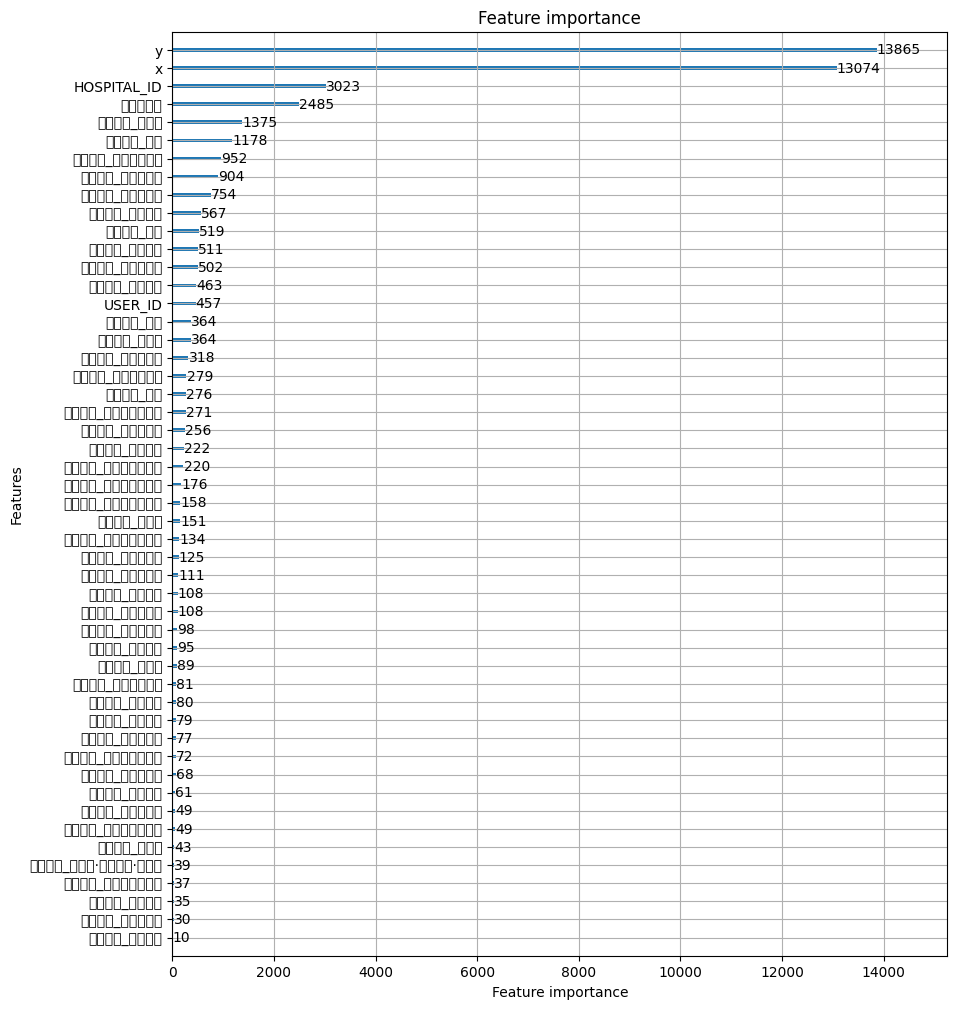

In [89]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()

### Optuna로 Tuning

In [90]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [147]:
sampler = TPESampler(seed=99) # 젤 많이 쓰이는 sampler, DL에서 optimizer 느낌

def objective(trial):
    dtrain = Dataset(X_train, label = y_train)
    dtest = Dataset(X_test, label = y_test)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mae', 
        'max_depth': trial.suggest_int('max_depth', 3, 15),        # suggest_int 정수로 이동하면서 학습
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2), # suggest_loguniform 함수를 써 줘야 소수점을 따라 학습
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param) # ** = 가변적이라는 뜻
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    mse = mean_squared_error(y_test, lgb_model.predict(X_test))
    return mse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=50)

[I 2022-12-09 11:39:31,342] A new study created in memory with name: no-name-29562196-ca67-4400-81a2-2ed60bdd4859
[I 2022-12-09 11:39:46,537] Trial 0 finished with value: 4.587523784964134 and parameters: {'max_depth': 11, 'learning_rate': 8.481455649341929e-06, 'n_estimators': 2494, 'min_child_samples': 8, 'subsample': 0.83871691292512}. Best is trial 0 with value: 4.587523784964134.
[I 2022-12-09 11:39:47,965] Trial 1 finished with value: 4.618488619920208 and parameters: {'max_depth': 10, 'learning_rate': 6.105693399947273e-07, 'n_estimators': 235, 'min_child_samples': 100, 'subsample': 0.4025095820996999}. Best is trial 0 with value: 4.587523784964134.
[I 2022-12-09 11:39:55,452] Trial 2 finished with value: 4.22942285664498 and parameters: {'max_depth': 13, 'learning_rate': 0.00030241449674836465, 'n_estimators': 1194, 'min_child_samples': 52, 'subsample': 0.936970079196895}. Best is trial 2 with value: 4.22942285664498.
[I 2022-12-09 11:40:03,189] Trial 3 finished with value: 3.8

[I 2022-12-09 11:44:39,732] Trial 28 finished with value: 4.1787816387474885 and parameters: {'max_depth': 7, 'learning_rate': 0.00018459782867455673, 'n_estimators': 2659, 'min_child_samples': 38, 'subsample': 0.5952162720640259}. Best is trial 21 with value: 3.8022992925264303.
[I 2022-12-09 11:44:52,998] Trial 29 finished with value: 4.584182350333246 and parameters: {'max_depth': 10, 'learning_rate': 9.84221795810895e-06, 'n_estimators': 2420, 'min_child_samples': 15, 'subsample': 0.5419616315967595}. Best is trial 21 with value: 3.8022992925264303.
[I 2022-12-09 11:45:04,398] Trial 30 finished with value: 4.6077194720478705 and parameters: {'max_depth': 14, 'learning_rate': 3.7312047590015005e-06, 'n_estimators': 1969, 'min_child_samples': 87, 'subsample': 0.9968810303621859}. Best is trial 21 with value: 3.8022992925264303.
[I 2022-12-09 11:45:17,345] Trial 31 finished with value: 3.7866902290523647 and parameters: {'max_depth': 15, 'learning_rate': 0.004624565169981161, 'n_estim

### 위 코드에서 파라미터 추출하고 추가 학습까지 진행해 줘야 함

In [148]:
trial_params = {'max_depth': 23, 'learning_rate': 0.00990323848202835, 'n_estimators': 846, 'min_child_samples': 24, 'subsample': 0.8701277798440029}
trial_params2 = {'max_depth': 20, 'learning_rate': 0.009842725311877134, 'n_estimators': 2018, 'min_child_samples': 26, 'subsample': 0.4715832342831849}
trial_params3 = {'max_depth': 24, 'learning_rate': 0.008927289793026653, 'n_estimators': 4544, 'min_child_samples': 5, 'subsample': 0.40621052807670843}
trial_params4 = {'max_depth': 20, 'learning_rate': 0.003025159791216834, 'n_estimators': 2788, 'min_child_samples': 47, 'subsample': 0.8177492492343691}
trial_params5 = {'max_depth': 16, 'learning_rate': 0.021480437310798683, 'n_estimators': 1733, 'min_child_samples': 47, 'subsample': 0.6474291809870388}
trial_params6 = {'max_depth': 15, 'learning_rate': 0.004624565169981161, 'n_estimators': 2995, 'min_child_samples': 5, 'subsample': 0.7079717028641825}



In [149]:
final_lgb_model = LGBMRegressor(**trial_params6)
final_lgb_model.fit(X_train, y_train)
final_lgb_pred = final_lgb_model.predict(X_test)
mean_squared_error(final_lgb_pred, y_test.values)

3.7866902290523647

In [150]:
final_lgb_pred = final_lgb_model.predict(Final_Test_X)
final_lgb_pred

array([7.78063499, 8.87947039, 7.78063499, ..., 7.38989812, 7.6716084 ,
       8.94926396])

In [120]:
# around
final_lgb_pred_around = np.around(final_lgb_pred)
final_lgb_pred_around

array([9., 9., 9., ..., 9., 9., 9.])

In [151]:
# ceil 소수점 올림
final_lgb_pred_ceil = np.ceil(final_lgb_pred)
final_lgb_pred_ceil

array([8., 9., 8., ..., 8., 8., 9.])

In [ ]:
# trunc, 버림
final_lgb_pred_trunc = np.trunc(final_lgb_pred)
final_lgb_pred_trunc

In [ ]:
final_lgb_pred_around

In [124]:
# 예상 값의 범위 맞춰주기, around, 반올림

final_lgb_pred_around = np.where(final_lgb_pred_around > 10, 10, final_lgb_pred_around)
final_lgb_pred_around = np.where(final_lgb_pred_around < 0, 0, final_lgb_pred_around)
submission['Predict_Score'] = final_lgb_pred_around
submission['Predict_Score'].value_counts()

9.0     881
8.0     354
7.0     108
10.0     36
6.0      26
5.0       1
Name: Predict_Score, dtype: int64

In [153]:
# 예상 값의 범위 맞춰주기, ceil

final_lgb_pred_ceil = np.where(final_lgb_pred_ceil > 10, 10, final_lgb_pred_ceil)
final_lgb_pred_ceil = np.where(final_lgb_pred_ceil < 0, 0, final_lgb_pred_ceil)
submission['Predict_Score'] = final_lgb_pred_ceil
submission['Predict_Score'].value_counts()

8.0     1155
9.0      172
7.0       56
10.0      21
6.0        2
Name: Predict_Score, dtype: int64

In [ ]:
# 예상 값의 범위 맞춰주기, trunc

final_lgb_pred_trunc = np.where(final_lgb_pred_trunc > 10, 10, final_lgb_pred_trunc)
final_lgb_pred_trunc = np.where(final_lgb_pred_trunc < 0, 0, final_lgb_pred_trunc)
submission['Predict_Score'] = final_lgb_pred_trunc
submission['Predict_Score'].value_counts()

In [104]:
optuna.visualization.plot_param_importances(study_lgb)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

제출

In [154]:
submission['Predict_Score'] = final_lgb_pred_around

path = './result/'

now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
submission.to_csv(f'{path}Submission_{now}.csv',encoding='utf-8', index=False)